<a href="https://colab.research.google.com/github/EdWangLoDaSc/AIDD-LSD1-BNN-VAE/blob/main/GRAPH_lorenz_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D,ConvLSTM2D,Conv3D,Cropping2D
from keras.layers import Input, Dropout, TimeDistributed, RepeatVector,Activation
from keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization,Flatten, Dense, Reshape, LSTM
from keras import losses, Sequential
from keras import layers
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.optimizers import RMSprop, Adam
import keras

# Create an empty graph, 平均度=25， 1000 nodes
G = nx.barabasi_albert_graph(1000, 2) 

# Define the Lorenz system parameters,混沌系统，try different paramsters,general+test differentr models
sigma = 1
rho = 1.5
beta = 8/3

# Define the initial state of the nodes，+interval
initial_state = np.random.rand(1000, 3)

# Define the coupling strength
alpha = 0.1

# Plot the final state of the nodes
#plt.hist(current_state[:,0])
#plt.show()

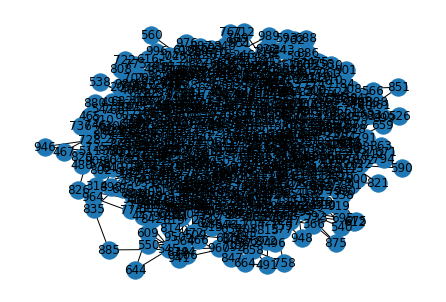

In [ ]:
nx.draw(G, with_labels=True)


For timestepm, should try
input length = out length
不同的参数
看节点之间差别的大
range-成train datasets 
Train GCNLstm
Train LSTM


# Some Functions

In [3]:
# Some fixed papamesters: G(1000,2),  alpha:0.1
def G_Lorenz(sigma,rho,beta,time_steps):

    historical_state = np.zeros((time_steps,500,3))
    current_state = initial_state
    for i in range(time_steps):
        current_state = update_state(G, current_state, alpha, sigma, rho, beta)
        historical_state[i,:,:] = current_state
    
    return current_state,historical_state

def update_state(G, state, alpha, sigma, rho, beta):
    new_state = state.copy()
    for node in G.nodes():
        neighbors = G.neighbors(node)
        x, y, z = state[node]
        dx = sigma*(y - x)
        dy = x*(rho - z) - y
        dz = x*y - beta*z
        dx_neigh, dy_neigh, dz_neigh = np.mean([state[neighbor] for neighbor in neighbors], axis=0)
        new_state[node] = state[node] + alpha*np.array([dx+dx_neigh, dy+dy_neigh, dz+dz_neigh])
    return new_state



In [4]:
G = nx.barabasi_albert_graph(500, 2) 
initial_state = np.random.rand(500, 3)


# Type 1

## 2,3.5,8/3

In [84]:
current_state_1, historical_state_1 = G_Lorenz(2,3.5,8/3,40000)

In [85]:
historical_state_1.shape

(40000, 500, 3)

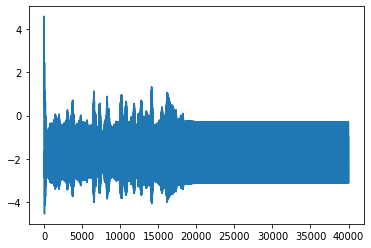

In [87]:
plt.plot(historical_state_1[:40000,492,1])

## 2,3,8/3

In [111]:
current_state_t2, historical_state_t2 = G_Lorenz(2,3,8/3,6000)

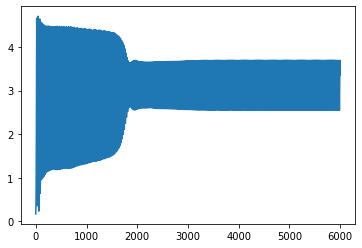

In [112]:
plt.plot(historical_state_t2[:,490,0])


In [ ]:
current_state_t, historical_state_t = G_Lorenz(2,2.5,8/3,10000)

## 2，3，3

In [299]:
current_state_t3, historical_state_t3 = G_Lorenz(4,2.5,3,2000)

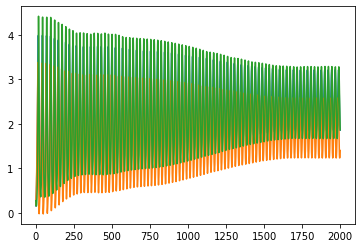

In [300]:
 plt.plot(historical_state_t3[:,490,:])

## 2,2,8/3 

In [145]:
current_state_1, historical_state_1 = G_Lorenz(2,2,8/3,2000)

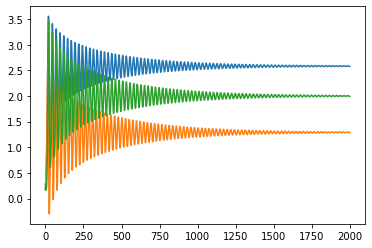

In [146]:
plt.plot(historical_state_1[:,490,:])

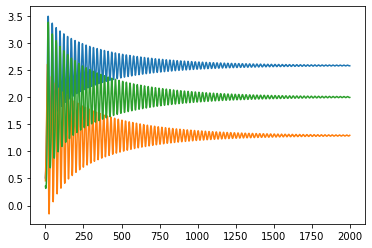

In [148]:
plt.plot(historical_state_1[:,400,:])

## 1, 3, 2

In [10]:
current_state_3, historical_state_3 = G_Lorenz(1,3,2,70)

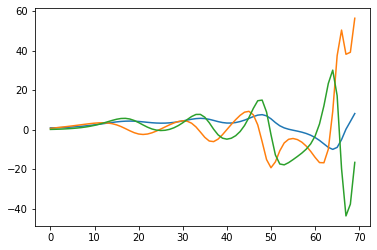

In [11]:
plt.plot(historical_state_3[:,500,:])

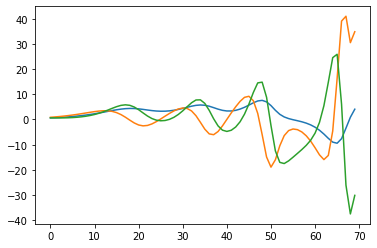

In [12]:
plt.plot(historical_state_3[:,501,:])

## 3, 3,8/3

In [13]:
current_state_4, historical_state_4 = G_Lorenz(3,1,8/3,300)

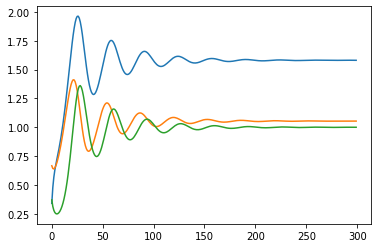

In [14]:
plt.plot(historical_state_4[:,503,:])

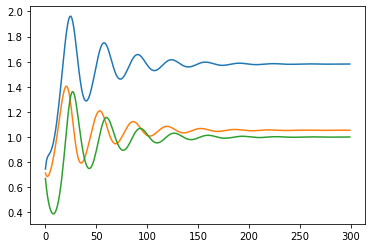

In [15]:
plt.plot(historical_state_4[:,999,:])

# 1, 1.5,8/3

In [24]:
current_state_5, historical_state_5 = G_Lorenz(1,1.5,8/3,110)

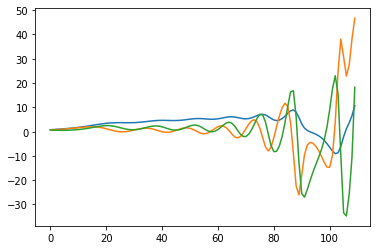

In [25]:
plt.plot(historical_state_5[:,999,:])

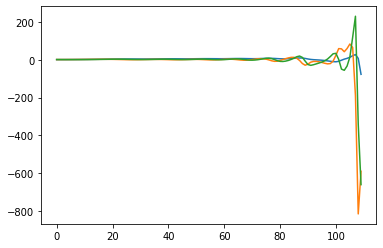

In [26]:
plt.plot(historical_state_5[:,2,:])

# 1, 1,8/3

In [19]:
current_state_6, historical_state_6 = G_Lorenz(1,1,8/3,140)

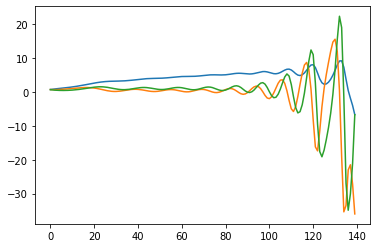

In [20]:
plt.plot(historical_state_6[:,999,:])

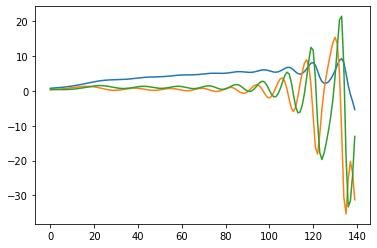

In [21]:
plt.plot(historical_state_6[:,990,:])

In [22]:
historical_state_6.shape

(140, 1000, 3)

In [23]:
叠加起来，140*3000 5-5

SyntaxError: ignored

In [78]:
#train_dataset = np.vstack((historical_state_1,historical_state_2,historical_state_3,historical_state_4,historical_state_5,historical_state_6))
train_dataset = historical_state_1

In [79]:
train_dataset.shape

(2000, 1000, 3)

In [80]:
#datasets = train_dataset.reshape(2680,3000)

datasets = train_dataset.reshape(2000,3000)
train = datasets[:1700,:]
valid = datasets[1700:,:]

In [47]:
train.shape

(1700, 3000)

# LSTM_1


In [266]:
#train_dataset = np.vstack((historical_state_1,historical_state_t2,historical_state_t3))
train_dataset = historical_state_1
train_len = len(train_dataset)
datasets = train_dataset.reshape(train_len,1500)
train = datasets[:1500,:]
valid = datasets[1500:,:]


In [267]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

train_sca = scaler.fit_transform(train).astype('float32')
test_sca = scaler.transform(valid).astype('float32')
slices_train = np.split(train_sca, len(train)/4)
train_dataset = np.stack(slices_train, axis=0)
slices_test = np.split(test_sca, len(valid)/4)
val_dataset = np.stack(slices_test, axis=0)

In [245]:
train_dataset.shape

(375, 4, 1500)

In [268]:
def create_shifted_frames(data):
    x = data[0 : data.shape[0] - 1, :, :]
    y = data[1 : data.shape[0], :, :]
    return x, y
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)
x_train.shape

(374, 4, 1500)

In [269]:
model = Sequential()

model.add(LSTM(64,input_shape=(4,1500)))
model.add(Dropout(0.25))

model.add(RepeatVector(4))

#multi-step
model.add(LSTM(64, activation='relu', return_sequences=True))

#model.add(Dropout(0.25))
#model.add(BatchNormalization())



#model.add(Dense(128))


model.add(TimeDistributed(Dense(1500)))

model.add(Activation('relu'))

##################################################################
#training

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 64)                400640    
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 repeat_vector_25 (RepeatVec  (None, 4, 64)            0         
 tor)                                                            
                                                                 
 lstm_51 (LSTM)              (None, 4, 64)             33024     
                                                                 
 time_distributed_25 (TimeDi  (None, 4, 1500)          97500     
 stributed)                                                      
                                                                 
 activation_25 (Activation)  (None, 4, 1500)         

In [270]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
history = model.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=100,callbacks=[early_stopping, reduce_lr],batch_size=1, verbose=1)

Epoch 1/100
374/374 [==============================] - 6s 11ms/step - loss: 0.0656 - mae: 0.1694 - val_loss: 0.0363 - val_mae: 0.1031 - lr: 0.0010
Epoch 2/100
374/374 [==============================] - 3s 9ms/step - loss: 0.0431 - mae: 0.1278 - val_loss: 0.0403 - val_mae: 0.1553 - lr: 0.0010
Epoch 3/100
374/374 [==============================] - 4s 10ms/step - loss: 0.0323 - mae: 0.1090 - val_loss: 0.0261 - val_mae: 0.1162 - lr: 0.0010
Epoch 4/100
374/374 [==============================] - 4s 10ms/step - loss: 0.0227 - mae: 0.0865 - val_loss: 0.0122 - val_mae: 0.0332 - lr: 0.0010
Epoch 5/100
374/374 [==============================] - 4s 10ms/step - loss: 0.0171 - mae: 0.0768 - val_loss: 0.0085 - val_mae: 0.0278 - lr: 0.0010
Epoch 6/100
374/374 [==============================] - 3s 9ms/step - loss: 0.0130 - mae: 0.0655 - val_loss: 0.0076 - val_mae: 0.0487 - lr: 0.0010
Epoch 7/100
374/374 [==============================] - 3s 9ms/step - loss: 0.0101 - mae: 0.0585 - val_loss: 0.0052 - val

In [271]:
trainPredict = model.predict(x_train)
trainPredict.shape

12/12 [==============================] - 0s 3ms/step


(374, 4, 1500)

In [272]:
trainPredict = model.predict(x_train).reshape((1496,1500))
testPredict = model.predict(x_val).reshape((496,1500))
y_train = y_train.reshape((1496,1500)) 
y_val = y_val.reshape((496,1500))  

4/4 [==============================] - 0s 5ms/step


In [273]:
trainPredict = scaler.inverse_transform(trainPredict).reshape(1496,500,3)
trainY = scaler.inverse_transform(y_train).reshape(1496,500,3)
testPredict = scaler.inverse_transform(testPredict).reshape(496,500,3)
testY = scaler.inverse_transform(y_val).reshape(496,500,3)

x_train = scaler.inverse_transform(x_train.reshape(1496,1500))


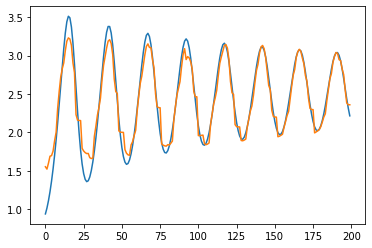

In [275]:
plt.plot(trainY[:200,200,0])
plt.plot(trainPredict[:200,200,0])


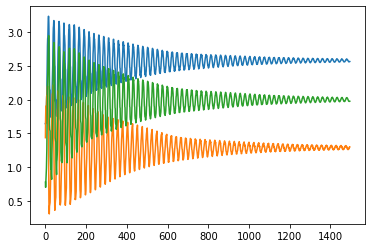

In [280]:
plt.plot(trainPredict[:,100,:])


# LSTM_2


In [362]:
#train_dataset = np.vstack((historical_state_1,historical_state_t2,historical_state_t3))
train_dataset = historical_state_t3
train_len = len(train_dataset)
datasets = train_dataset.reshape(train_len,1500)
train = datasets[:1500,:]
valid = datasets[1500:,:]

scaler = MinMaxScaler(feature_range=(0, 1))

train_sca = scaler.fit_transform(train).astype('float32')
test_sca = scaler.transform(valid).astype('float32')
slices_train = np.split(train_sca, len(train)/4)
train_dataset = np.stack(slices_train, axis=0)
slices_test = np.split(test_sca, len(valid)/4)
val_dataset = np.stack(slices_test, axis=0)

def create_shifted_frames(data):
    x = data[0 : data.shape[0] - 1, :, :]
    y = data[1 : data.shape[0], :, :]
    return x, y
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)
x_train.shape

(374, 4, 1500)

In [363]:
model = Sequential()

model.add(LSTM(100,input_shape=(4,1500)))
#model.add(Dropout(0.25))

model.add(RepeatVector(4))

#multi-step
model.add(LSTM(64, activation='relu', return_sequences=True))

#model.add(Dropout(0.25))
#model.add(BatchNormalization())



#model.add(Dense(32))


model.add(TimeDistributed(Dense(1500)))

model.add(Activation('relu'))

##################################################################
#training

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_77 (LSTM)              (None, 100)               640400    
                                                                 
 repeat_vector_39 (RepeatVec  (None, 4, 100)           0         
 tor)                                                            
                                                                 
 lstm_78 (LSTM)              (None, 4, 64)             42240     
                                                                 
 time_distributed_39 (TimeDi  (None, 4, 1500)          97500     
 stributed)                                                      
                                                                 
 activation_39 (Activation)  (None, 4, 1500)           0         
                                                                 
Total params: 780,140
Trainable params: 780,140
Non-t

In [364]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
history = model.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=100,callbacks=[early_stopping, reduce_lr],batch_size=1, verbose=1)

Epoch 1/100
374/374 [==============================] - 6s 11ms/step - loss: 0.0671 - mae: 0.1779 - val_loss: 0.0265 - val_mae: 0.0993 - lr: 0.0010
Epoch 2/100
374/374 [==============================] - 3s 9ms/step - loss: 0.0244 - mae: 0.0964 - val_loss: 0.0237 - val_mae: 0.1039 - lr: 0.0010
Epoch 3/100
374/374 [==============================] - 4s 10ms/step - loss: 0.0171 - mae: 0.0806 - val_loss: 0.0163 - val_mae: 0.0822 - lr: 0.0010
Epoch 4/100
374/374 [==============================] - 4s 10ms/step - loss: 0.0130 - mae: 0.0716 - val_loss: 0.0134 - val_mae: 0.0737 - lr: 0.0010
Epoch 5/100
374/374 [==============================] - 3s 9ms/step - loss: 0.0108 - mae: 0.0660 - val_loss: 0.0140 - val_mae: 0.0825 - lr: 0.0010
Epoch 6/100
374/374 [==============================] - 3s 9ms/step - loss: 0.0097 - mae: 0.0627 - val_loss: 0.0109 - val_mae: 0.0679 - lr: 0.0010
Epoch 7/100
374/374 [==============================] - 3s 9ms/step - loss: 0.0087 - mae: 0.0589 - val_loss: 0.0118 - val_

In [365]:
trainPredict = model.predict(x_train)
trainPredict = model.predict(x_train).reshape((1496,1500))
testPredict = model.predict(x_val).reshape((496,1500))
y_train = y_train.reshape((1496,1500)) 
y_val = y_val.reshape((496,1500)) 

trainPredict = scaler.inverse_transform(trainPredict).reshape(1496,500,3)
trainY = scaler.inverse_transform(y_train).reshape(1496,500,3)
testPredict = scaler.inverse_transform(testPredict).reshape(496,500,3)
testY = scaler.inverse_transform(y_val).reshape(496,500,3)

x_train = scaler.inverse_transform(x_train.reshape(1496,1500))


4/4 [==============================] - 0s 4ms/step


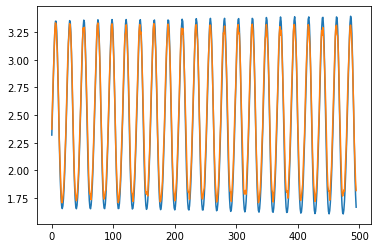

In [367]:
plt.plot(testY[:,200,0])
plt.plot(testPredict[:,200,0])

# historical_state_4

In [106]:
historical_state_4.shape

(300, 1000, 3)

In [109]:
train_dataset = historical_state_4
datasets = train_dataset.reshape(300,3000)
train = datasets[:250,:]
valid = datasets[250:,:]

In [110]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

train_sca = scaler.fit_transform(train).astype('float32')
test_sca = scaler.transform(valid).astype('float32')
slices_train = np.split(train_sca, len(train)/5)
train_dataset = np.stack(slices_train, axis=0)
slices_test = np.split(test_sca, len(valid)/5)
val_dataset = np.stack(slices_test, axis=0)

def create_shifted_frames(data):
    x = data[0 : data.shape[0] - 1, :, :]
    y = data[1 : data.shape[0], :, :]
    return x, y
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)
x_train.shape

(49, 5, 3000)

In [112]:
model = Sequential()

model.add(LSTM(128,input_shape=(5,3000)))
model.add(Dropout(0.3))

model.add(RepeatVector(5))

#multi-step
model.add(LSTM(128, activation='relu', return_sequences=True))
#model.add(BatchNormalization())

#model.add(Dropout(0.3))
#model.add(BatchNormalization())


#model.add(Dense(50))

model.add(Dense(128))
#model.add(BatchNormalization())


model.add(TimeDistributed(Dense(3000)))

model.add(Activation('relu'))

##################################################################
#training

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 128)               1602048   
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_11 (RepeatVec  (None, 5, 128)           0         
 tor)                                                            
                                                                 
 lstm_23 (LSTM)              (None, 5, 128)            131584    
                                                                 
 dense_22 (Dense)            (None, 5, 128)            16512     
                                                                 
 time_distributed_11 (TimeDi  (None, 5, 3000)          387000    
 stributed)                                          

In [113]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
history = model.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=100,callbacks=[early_stopping, reduce_lr],batch_size=1, verbose=1)

Epoch 1/100
49/49 [==============================] - 5s 40ms/step - loss: 0.1723 - mae: 0.3219 - val_loss: 0.0954 - val_mae: 0.1776 - lr: 0.0010
Epoch 2/100
49/49 [==============================] - 1s 28ms/step - loss: 0.1040 - mae: 0.2111 - val_loss: 0.0848 - val_mae: 0.1484 - lr: 0.0010
Epoch 3/100
49/49 [==============================] - 1s 29ms/step - loss: 0.0962 - mae: 0.1966 - val_loss: 0.0810 - val_mae: 0.1454 - lr: 0.0010
Epoch 4/100
49/49 [==============================] - 1s 28ms/step - loss: 0.0923 - mae: 0.1929 - val_loss: 0.0759 - val_mae: 0.1336 - lr: 0.0010
Epoch 5/100
49/49 [==============================] - 1s 27ms/step - loss: 0.0897 - mae: 0.1966 - val_loss: 0.0749 - val_mae: 0.1495 - lr: 0.0010
Epoch 6/100
49/49 [==============================] - 1s 28ms/step - loss: 0.0844 - mae: 0.1830 - val_loss: 0.0729 - val_mae: 0.1474 - lr: 0.0010
Epoch 7/100
49/49 [==============================] - 1s 28ms/step - loss: 0.0850 - mae: 0.1843 - val_loss: 0.0827 - val_mae: 0.218

In [117]:
trainPredict = model.predict(x_train).reshape((245,3000))
testPredict = model.predict(x_val).reshape((45,3000))
y_train = y_train.reshape((245,3000)) 
y_val = y_val.reshape((45,3000))  

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict).reshape(45,1000,3)
testY = scaler.inverse_transform(y_val).reshape(45,1000,3)

x_train = scaler.inverse_transform(x_train.reshape(245,3000))


1/1 [==============================] - 0s 26ms/step


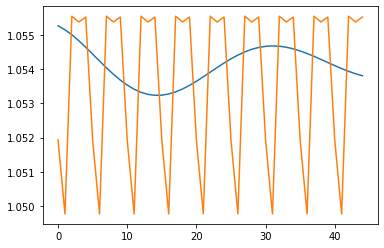

In [118]:
plt.plot(testY[:,990,1])
plt.plot(testPredict[:,990,1])